# Imports + Path Specification

In [2]:
import sys
import os
import torch
from torch import optim
from time import time

In [3]:
tile2vec_dir = '/home/agupta21/gcloud/231n_gitproject'
sys.path.append('../')
sys.path.append(tile2vec_dir)

In [4]:
from src.datasets import TileTripletsDataset, GetBands, RandomFlipAndRotate, ClipAndScale, ToFloatTensor, triplet_dataloader
from src.tilenet import make_tilenet

In [5]:
from src.training import prep_triplets, train_triplet_epoch

In [6]:
import numpy as np
from torch.autograd import Variable
import sys
from src.resnet import ResNet18

In [7]:
#Random Forest Classification

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Dataloader + TileNet Setup

In [8]:
# Environment stuff
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()
print(cuda)

True


In [9]:
# Defining Parameters
img_type = 'naip'
tile_dir = '/home/agupta21/gcloud/231n_gitproject/data/triplets/'
bands = 4
augment = False
batch_size = 50
shuffle = True
num_workers = 4
n_triplets = 108700 #modification: adding 8700 more for semi-supervised learning purposes

In [10]:
dataloader = triplet_dataloader(img_type, tile_dir, bands=bands, augment=augment,
                                batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, 
                                n_triplets=n_triplets, pairs_only=True)
print('Dataloader set up complete.')

Dataloader set up complete.


In [11]:
in_channels = bands
z_dim = 512

In [12]:
TileNet = make_tilenet(in_channels=in_channels, z_dim=z_dim, strat2=False)
TileNet.train()
if cuda: TileNet.cuda()
print('TileNet set up complete.')

TileNet set up complete.


In [13]:
#Hyperparameter 
lr = 0.0003 #hyper tuned
optimizer = optim.Adam(TileNet.parameters(), lr=lr, betas=(0.9, 0.999)) #hyper tuned

# Training Model + Writing Each Epoch to File

In [14]:
epochs = 10
margin = 10
l2 = 0.01
print_every = 10000
save_models = True

In [15]:
model_dir = '/home/agupta21/gcloud/231n_gitproject/models/'
if not os.path.exists(model_dir): os.makedirs(model_dir)

In [16]:
t0 = time()
#with open(results_fn, 'w') as file:

plot_list = []
print('Begin training.................')
for epoch in range(0, epochs):
    (avg_loss, bullshit, avg_l_n, avg_l_d, avg_l_nd) = train_triplet_epoch(
        TileNet, cuda, dataloader, optimizer, epoch+1, margin=margin, l2=l2,
        print_every=print_every, t0=t0)
    plot_list.append((epoch+1,avg_loss))
    append_name = "strat1ht1_ep" + str(epoch+1) + ".ckpt"
    if save_models:
        model_fn = os.path.join(model_dir,append_name)
        torch.save(TileNet.state_dict(),model_fn)

Begin training.................
Epoch 1: [10000/108700 (9%)], Avg loss: 6.0657
Epoch 1: [20000/108700 (18%)], Avg loss: 5.3830
Epoch 1: [30000/108700 (28%)], Avg loss: 5.0873
Epoch 1: [50000/108700 (46%)], Avg loss: 4.9285
Epoch 1: [60000/108700 (55%)], Avg loss: 4.7964
Epoch 1: [70000/108700 (64%)], Avg loss: 4.8594
Epoch 1: [80000/108700 (74%)], Avg loss: 4.6677
Epoch 1: [90000/108700 (83%)], Avg loss: 4.7307
Epoch 1: [100000/108700 (92%)], Avg loss: 4.6602
Epoch 2: [10000/108700 (9%)], Avg loss: 4.6709
Epoch 2: [20000/108700 (18%)], Avg loss: 4.6138
Epoch 2: [30000/108700 (28%)], Avg loss: 4.5226
Epoch 2: [40000/108700 (37%)], Avg loss: 4.5351
Epoch 2: [50000/108700 (46%)], Avg loss: 4.5406
Epoch 2: [60000/108700 (55%)], Avg loss: 4.5161
Epoch 2: [70000/108700 (64%)], Avg loss: 4.4106
Epoch 2: [80000/108700 (74%)], Avg loss: 4.4889
Epoch 2: [90000/108700 (83%)], Avg loss: 4.4245
Epoch 2: [100000/108700 (92%)], Avg loss: 4.4215
Finished epoch 2: 5658.949s
  Average loss: 4.5061
  Ave

In [17]:
print(plot_list)


[(1, 4.983395866329997), (2, 4.506065688444697), (3, 4.296001369292953), (4, 4.164814760077405), (5, 4.090833804644679), (6, 4.013302650600809), (7, 3.9560943651111606), (8, 3.909276813460581), (9, 3.861001264423872), (10, 3.8094547690880223)]


# Pre Process Y Values

In [18]:
#note to self: need to embed tiles first and then figure out loop for reading in the saved model and plotting
#the classification accuracies per epoch
tile_dir = '../data/tiles'
n_tiles = 1000
y = np.load(os.path.join(tile_dir, 'y.npy'))
print(y.shape)
#print(set(y))

(1000,)


In [19]:
# Check CDL classes
print(set(y))

{1.0, 2.0, 21.0, 24.0, 152.0, 28.0, 36.0, 176.0, 49.0, 54.0, 61.0, 69.0, 71.0, 72.0, 75.0, 76.0, 205.0, 204.0, 208.0, 212.0, 217.0, 225.0, 236.0, 111.0, 121.0, 122.0, 123.0, 124.0}


In [20]:
y = LabelEncoder().fit_transform(y)
print(set(y))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}


# Load in Epochs' Weights + Run each on tile embeddings + Random Forest 

In [21]:
#set up model
in_channels = 4
z_dim = 512
cuda = torch.cuda.is_available()

In [22]:
def getTileEmbeddings(tilenet):
    X = np.zeros((n_tiles, z_dim))
    for idx in range(n_tiles):
        tile = np.load(os.path.join(tile_dir, '{}tile.npy'.format(idx+1)))
        # Get first 4 NAIP channels (5th is CDL mask)
        tile = tile[:,:,:4]
        # Rearrange to PyTorch order
        tile = np.moveaxis(tile, -1, 0)
        tile = np.expand_dims(tile, axis=0)
        # Scale to [0, 1]
        tile = tile / 255
        # Embed tile
        tile = torch.from_numpy(tile).float()
        tile = Variable(tile)
        if cuda: tile = tile.cuda()
        z = tilenet.encode(tile)
        if cuda: z = z.cpu()
        z = z.data.numpy() #1 by 512
        X[idx,:] = z
    return X

In [23]:
epochsToAccuracy = []
epochsToSTD = []
for i in range(0,epochs): #iterator
    curEpoch = i + 1
    # Setting up model
    tilenet = ResNet18()
    if cuda: tilenet.cuda()
    model_fn = "../models/strat1ht1_ep"+str(curEpoch)+".ckpt" #open file
    #checkpoint = torch.load(model_fn)
    tilenet.load_state_dict(torch.load(model_fn), strict=False)
    #tilenet.load_state_dict(checkpoint)
    tilenet.eval()
    
    X = getTileEmbeddings(tilenet) #function above
    
    #train random forest classifier
    n_trials = 100
    accs = np.zeros((n_trials,))
    for i in range(n_trials):
        # Splitting data and training RF classifer
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X_tr, y_tr) #X-tr is 512 by 1
        accs[i] = rf.score(X_te, y_te)
    print("Results for Epoch Number: ", str(curEpoch))
    print('Mean accuracy: {:0.4f}'.format(accs.mean()))
    print('Standard deviation: {:0.4f}'.format(accs.std()))
    epochsToAccuracy.append((curEpoch,accs.mean()))
    epochsToSTD.append((curEpoch,accs.std()))
print(epochsToAccuracy)
print(epochsToSTD)
    #save value
    
    
    
    

Results for Epoch Number:  1
Mean accuracy: 0.6844
Standard deviation: 0.0322
Results for Epoch Number:  2
Mean accuracy: 0.6877
Standard deviation: 0.0309
Results for Epoch Number:  3
Mean accuracy: 0.6893
Standard deviation: 0.0323
Results for Epoch Number:  5
Mean accuracy: 0.6955
Standard deviation: 0.0326
Results for Epoch Number:  6
Mean accuracy: 0.7120
Standard deviation: 0.0322
Results for Epoch Number:  7
Mean accuracy: 0.7263
Standard deviation: 0.0285
Results for Epoch Number:  8
Mean accuracy: 0.7094
Standard deviation: 0.0281
Results for Epoch Number:  9
Mean accuracy: 0.7248
Standard deviation: 0.0302
Results for Epoch Number:  10
Mean accuracy: 0.7274
Standard deviation: 0.0329
[(1, 0.68435), (2, 0.6876999999999999), (3, 0.6892500000000001), (4, 0.7052499999999999), (5, 0.69545), (6, 0.7120000000000001), (7, 0.7263499999999997), (8, 0.7094499999999999), (9, 0.7248499999999999), (10, 0.7274)]
[(1, 0.03217650540378801), (2, 0.030946889989141056), (3, 0.032298413273719795)

In [24]:
print(epochsToSTD)

[(1, 0.03217650540378801), (2, 0.030946889989141056), (3, 0.032298413273719795), (4, 0.025033727249452877), (5, 0.03260440921102542), (6, 0.03222576608864403), (7, 0.028459225217844566), (8, 0.02811489818583734), (9, 0.030236195197147417), (10, 0.03292020656071284)]


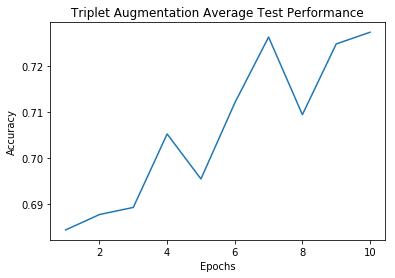

0.7274 was the Max Accuracy


In [28]:
import matplotlib.pyplot as plt
plt.plot(*zip(*epochsToAccuracy))
plt.title('Triplet Augmentation Average Test Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(epochsToAccuracy[9][1], "was the Max Accuracy")

The min loss was 3.8094547690880223


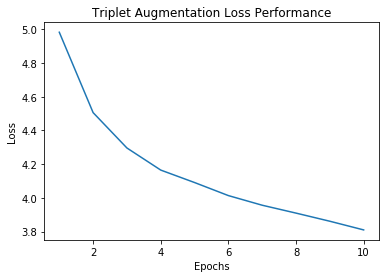

In [26]:
plt.plot(*zip(*plot_list))
plt.title('Triplet Augmentation Loss Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print("The min loss was",str(plot_list[9][1]))
plt.show()

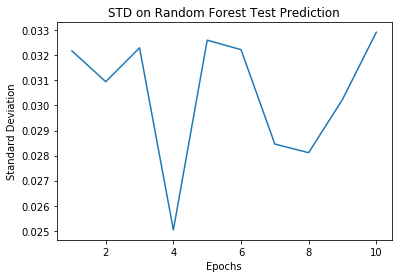

In [27]:
plt.plot(*zip(*epochsToSTD))
plt.title('STD on Random Forest Test Prediction')
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation')
plt.show()

# Code for Visualizations/Analysis

In [31]:
#iterator
i = 8
curEpoch = i + 1
# Setting up model
tilenet = ResNet18()
if cuda: tilenet.cuda()
model_fn = "../models/strat1ht1_ep"+str(curEpoch)+".ckpt" #open file
#checkpoint = torch.load(model_fn)
tilenet.load_state_dict(torch.load(model_fn), strict=False)
#tilenet.load_state_dict(checkpoint)
tilenet.eval()

X = getTileEmbeddings(tilenet) #function above

#train random forest classifier
n_trials = 100
accs = np.zeros((n_trials,))
#for i in range(n_trials):
    # Splitting data and training RF classifer
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_tr, y_tr) #X-tr is 512 by 1
rf_predictions = rf.predict(X_te)
print(rf_predictions.shape)
rf_probs = rf.predict_proba(X_te)[:, 1]
print(rf_probs.shape)

# from sklearn.metrics import roc_auc_score
# roc_value = roc_auc_score(y_te, rf_probs)
# print(roc_value)

#accs[i] = rf.score(X_te, y_te)
# print("Results for Epoch Number: ", str(curEpoch))
# print('Mean accuracy: {:0.4f}'.format(accs.mean()))
# print('Standard deviation: {:0.4f}'.format(accs.std()))
# epochsToAccuracy.append((curEpoch,accs.mean()))
# epochsToSTD.append((curEpoch,accs.std()))
# print(epochsToAccuracy)
# print(epochsToSTD)

(200,)
(200,)


In [32]:
print(y_te.shape)

(200,)


In [35]:
#classes
print(rf_predictions)
print(list(set(y)))

[20  9  8  9 17  9  9 12 12 20 12 20 17  9 17  9  9 12  5  9  9 20  9  9
  9 20  9  9  9 20  9 20  9 20  9  5 17  9  8  9 17 20 12 20 16 17  9  9
  9  9  5 12  9  9 14 20 20 12  9 12 20 12  9  9  9  8 17 12  9  9  9 17
  9  9  8  9  9 12  8 20 17  9 20 12 20  9  9 15  9 20  9  9  9  9  8 20
  6 20 12  9  9 17  8  9 20  9  9  9 20  5 20 20  9 12  8  9 12 12  9  9
  9  9  9 20  9 20 20 12 12  9 12  9 20 12 17  9 17 20  9 20  9 12  9  9
 12 12  9 12  1  9  9  9 20  8  5  9 12 20  5  8 12 12  9 17  9 12 15  9
 12  9 12  9 17 12  9  9  9 12  9 16  9 12 26 15  9  8 12  9  8  9  9  5
  9  9 20  5 17  9 22 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [38]:

from sklearn.metrics import confusion_matrix

y_true = y_te
y_pred = rf_predictions
classes = list(set(y))

confused= confusion_matrix(y_true, y_pred, labels=classes)
A = confused
print(confused.shape)
print('\n'.join([''.join(['{:4}'.format(item) for item in row]) 
      for row in A]))


(28, 28)
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   3   0   0   1   2   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   8   2   0   0   0   0   0   0   0   0   0   0   2   

In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(200,360))
    #plt.tight_layout()

Confusion matrix, without normalization


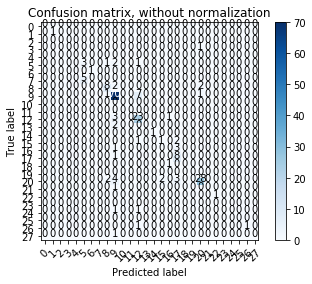

<Figure size 14400x25920 with 0 Axes>

In [55]:
cnf_matrix = confused
np.set_printoptions(precision=2)
import itertools

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

In [67]:
#try to get the RUC/AUC curve?
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier


#X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
classifier2 = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
y_tr2 = label_binarize(y_tr,classes=classes)
y_te2 = label_binarize(y_te,classes=classes)
y_score2 = classifier2.fit(X_tr, y_tr2).predict(X_te)

n_classes = len(classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_te2[:, i], y_score2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_te2.ravel(), y_score2.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# from collections import Counter
# Counter(y_true) # y_true must be your labels



/opt/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 27 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


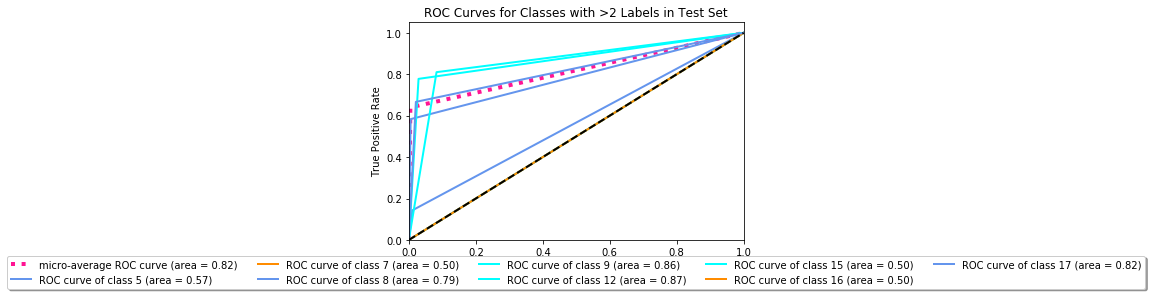

In [76]:
from scipy import interp
from itertools import cycle
import math

lw=2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(20), colors):
    if not math.isnan(roc_auc[i]):
        if np.count_nonzero(y_te == i) > 2:
            
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classes with >2 Labels in Test Set')
#plt.legend(loc="lower right")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()